Apple Stock (AAPL) Machine Learning Binary Classification

In [1]:
#Import Libraries
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
raw_df = yf.download('AAPL', start = '2010-01-01', end = '2025-07-26')
df = raw_df.copy() 

/var/folders/1p/bkw8vf0537qgpg1zgyfwq80r0000gn/T/ipykernel_33568/1667098571.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  raw_df = yf.download('AAPL', start = '2010-01-01', end = '2025-07-26')
[*********************100%***********************]  1 of 1 completed


In [3]:
raw_df.head()

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2010-01-04,6.431897,6.446624,6.382909,6.414466,493729600
2010-01-05,6.443018,6.479384,6.409056,6.449630,601904800
2010-01-06,6.340532,6.468563,6.333920,6.443017,552160000
2010-01-07,6.328810,6.371487,6.282827,6.363974,477131200
2010-01-08,6.370886,6.371487,6.283128,6.320395,447610800


In [4]:
df.columns = df.columns.droplevel(1)

In [5]:
df.head()

Price,Close,High,Low,Open,Volume
Date,,,,,
2010-01-04,6.431897,6.446624,6.382909,6.414466,493729600
2010-01-05,6.443018,6.479384,6.409056,6.449630,601904800
2010-01-06,6.340532,6.468563,6.333920,6.443017,552160000
2010-01-07,6.328810,6.371487,6.282827,6.363974,477131200
2010-01-08,6.370886,6.371487,6.283128,6.320395,447610800


In [6]:
df = df.reset_index()
df = df[['Date', 'Close', 'Open', 'High', 'Low', 'Volume']]

In [7]:
df.head()

Price,Date,Close,Open,High,Low,Volume
0,2010-01-04,6.431897,6.414466,6.446624,6.382909,493729600
1,2010-01-05,6.443018,6.449630,6.479384,6.409056,601904800
2,2010-01-06,6.340532,6.443017,6.468563,6.333920,552160000
3,2010-01-07,6.328810,6.363974,6.371487,6.282827,477131200
4,2010-01-08,6.370886,6.320395,6.371487,6.283128,447610800


In [8]:
df['Target'] = (df['Close'].shift(-1) > df['Close']).astype(int)
df = df.dropna()
df.head()

Price,Date,Close,Open,High,Low,Volume,Target
0,2010-01-04,6.431897,6.414466,6.446624,6.382909,493729600,1
1,2010-01-05,6.443018,6.449630,6.479384,6.409056,601904800,0
2,2010-01-06,6.340532,6.443017,6.468563,6.333920,552160000,0
3,2010-01-07,6.328810,6.363974,6.371487,6.282827,477131200,1
4,2010-01-08,6.370886,6.320395,6.371487,6.283128,447610800,0


In [9]:
#1-day return to capture the momentum of the stock
df['Return_1d'] = df['Close'].pct_change()

In [10]:
#5-day return
df['Return_5d'] = df['Close'].pct_change(5)
#2 and 3 day returns
df['Return_2d'] = df['Close'].pct_change(2)
df['Return_3d'] = df['Close'].pct_change(3)
df['Return_10d'] = df['Close'].pct_change(10)

In [11]:
#Moving averages for 10 days and 50 days, and their ratio
df['MA_10'] = df['Close'].rolling(10).mean()
df['MA_50'] = df['Close'].rolling(50).mean()
df['MA_ratio'] = df['MA_10'] / df['MA_50']

In [13]:
#5-day and 10-day volatility (standard deviation of returns)
df['Volatility_5d'] = df['Return_1d'].rolling(5).std()
df['Volatility_10d'] = df['Return_1d'].rolling(10).std()

In [14]:
#Date-Based Features
df['DayOfWeek'] = df['Date'].dt.dayofweek
df['Month'] = df['Date'].dt.month
df['Week'] = df['Date'].dt.isocalendar().week

In [15]:
#Volume Ratio
df['Volume_MA'] = df['Volume'].rolling(10).mean()
df['Volume_Ratio'] = df['Volume'] / df['Volume_MA']

In [16]:
#Return within a single day
df['IntraDay_Return'] = (df['Close'] - df['Open']) / df['Open']

In [17]:
#Daily Range: How much the stock moved within a day
df['Daily_Range'] = (df['High'] - df['Low']) / df['Close']

In [18]:
#14 day RSI
window = 14
delta = df['Close'].diff()
gain = delta.clip(lower = 0)
loss = - delta.clip(upper = 0)
avg_gain = gain.rolling(window).mean()
avg_loss = loss.rolling(window).mean()
rs = avg_gain / avg_loss
df['RSI'] = 100 - (100 / (1 + rs))

In [19]:
df.columns

Index(['Date', 'Close', 'Open', 'High', 'Low', 'Volume', 'Target', 'Return_1d',
       'Return_5d', 'Return_2d', 'Return_3d', 'Return_10d', 'MA_10', 'MA_50',
       'MA_ratio', 'Volatility_5d', 'Volatility_10d', 'DayOfWeek', 'Month',
       'Week', 'Volume_MA', 'Volume_Ratio', 'IntraDay_Return', 'Daily_Range',
       'RSI'],
      dtype='object', name='Price')

In [20]:
fig = px.line(df, x = 'Date', y = 'Close', title = 'Apple Stock (AAPL) Close Price (2010–2025)')
fig.update_xaxes(title_text = "Date")
fig.update_yaxes(title_text = "Adjusted Close Price (USD)")
fig.show()

In [21]:
stock_df = df[['Target', 
               'Return_1d', 'Return_2d', 'Return_3d',
               'Return_5d', 'Return_10d', 'MA_ratio', 'Volatility_5d', 'Volatility_10d',
               'Volume_Ratio', 'IntraDay_Return', 'Daily_Range',
               'DayOfWeek', 'Month', 'Week', 'RSI']].dropna()

In [22]:
stock_df.head()

Price,Target,Return_1d,Return_2d,Return_3d,Return_5d,Return_10d,MA_ratio,Volatility_5d,Volatility_10d,Volume_Ratio,IntraDay_Return,Daily_Range,DayOfWeek,Month,Week,RSI
49,0,0.002725,-0.009488,-0.004656,0.006412,0.074695,1.066074,0.007847,0.013426,0.835886,0.001204,0.011005,1,3,11,90.199340
50,1,-0.001470,0.001251,-0.010945,-0.003203,0.070654,1.072173,0.006863,0.013634,0.831192,-0.003468,0.014189,2,3,11,88.698365
51,0,0.002365,0.000891,0.003619,-0.003769,0.066157,1.077834,0.006794,0.013711,0.633362,0.002454,0.010639,3,3,11,87.806650
52,1,-0.010684,-0.008344,-0.009802,-0.019197,0.015072,1.078252,0.007135,0.008673,1.105337,-0.011299,0.018043,4,3,11,77.038915
53,1,0.011249,0.000445,0.002811,0.004065,0.025881,1.079510,0.007943,0.009185,0.897079,0.019413,0.026029,0,3,12,79.575682


In [23]:
stock_df.shape

(3865, 16)

In [24]:
stock_df = stock_df.reset_index(drop = True)

In [25]:
px.histogram(stock_df, x = 'Return_1d', color = 'Target', color_discrete_sequence = ['red', 'blue'])

In [26]:
px.histogram(stock_df, x = 'Return_2d', color = 'Target', color_discrete_sequence = ['red', 'blue'])

In [27]:
px.histogram(stock_df, x = 'Return_3d', color = 'Target', color_discrete_sequence = ['red', 'blue'])

In [28]:
px.histogram(stock_df, x = 'Return_5d', color = 'Target', color_discrete_sequence = ['red', 'blue'])

In [29]:
px.histogram(stock_df, x = 'MA_ratio', color = 'Target', color_discrete_sequence = ['red', 'blue'])

In [30]:
px.histogram(stock_df, x = 'Volatility_5d', color = 'Target', color_discrete_sequence = ['red', 'blue'])

In [31]:
px.histogram(stock_df, x = 'Volume_Ratio', color = 'Target', color_discrete_sequence = ['red', 'blue'])

In [32]:
px.histogram(stock_df, x = 'IntraDay_Return', color = 'Target', color_discrete_sequence = ['red', 'blue'])

In [33]:
px.histogram(stock_df, x = 'Daily_Range', color = 'Target', color_discrete_sequence = ['red', 'blue'])

In [34]:
px.histogram(stock_df, x = 'RSI', color = 'Target', color_discrete_sequence = ['red', 'blue'])

<Axes: xlabel='Target', ylabel='count'>

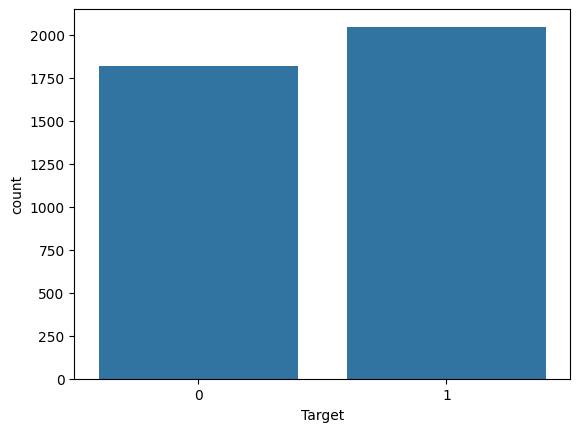

In [35]:
sns.countplot(data = stock_df, x = 'Target')

<Axes: xlabel='Target', ylabel='Daily_Range'>

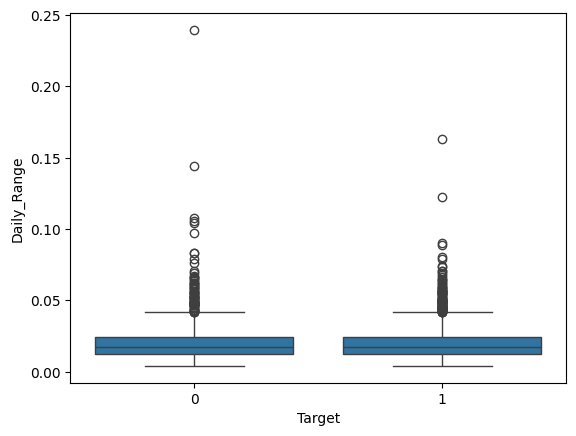

In [36]:
sns.boxplot(data = stock_df, x = 'Target', y = 'Daily_Range')

In [37]:
px.scatter(stock_df, x = 'Return_1d', y = 'Volatility_5d', color = stock_df['Target'].astype(str), color_discrete_sequence = ['red', 'blue'])

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/scipy/_lib/_util.py:1272: RuntimeWarning:

divide by zero encountered in vecdot

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/scipy/_lib/_util.py:1272: RuntimeWarning:

overflow encountered in vecdot

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/scipy/_lib/_util.py:1272: RuntimeWarning:

invalid value encountered in vecdot

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/scipy/_lib/_util.py:1272: RuntimeWarning:

divide by zero encountered in vecdot

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/scipy/_lib/_util.py:1272: RuntimeWarning:

overflow encountered in vecdot

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/scipy/_lib/_util.py:1272: RuntimeWarning:

invalid value encountered in vecdot

/Library/Frameworks/Python.framework/Versions/3.

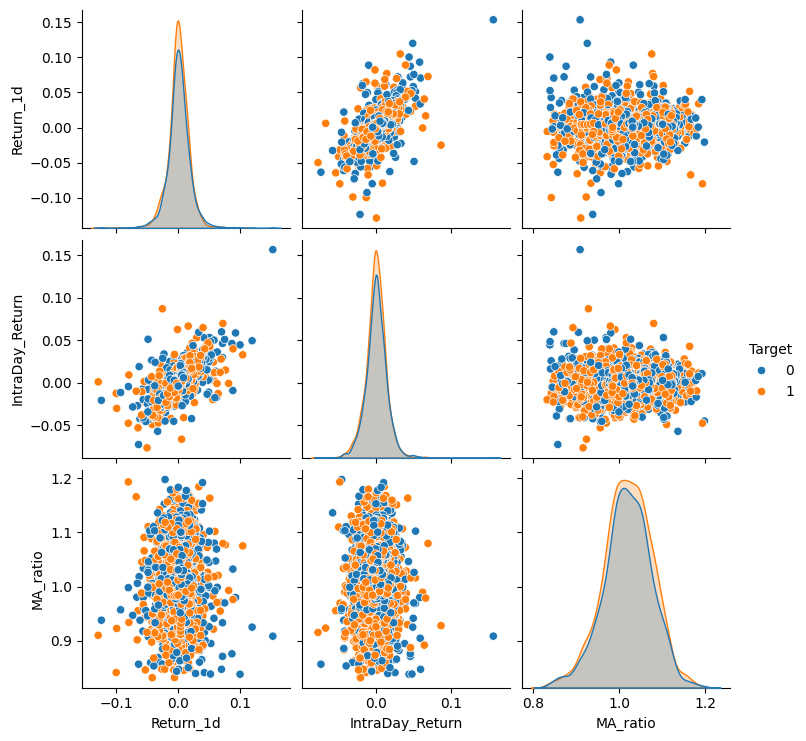

In [38]:
sns.pairplot(stock_df[['Return_1d', 'IntraDay_Return', 'MA_ratio', 'Target']], hue = 'Target')

In [39]:
numerical_columns = ['Return_1d', 'Return_2d', 'Return_3d', 'Return_5d', 'Return_10d',
                     'MA_ratio', 'Volatility_5d', 'Volatility_10d', 'Volume_Ratio',
                     'IntraDay_Return', 'Daily_Range', 'RSI']
#categorical_columns = ['DayOfWeek'] #, 'Month', 'Week']
X_inputs = stock_df[numerical_columns] # + categorical_columns]
Y_targets = stock_df['Target']

In [40]:
X_train, X_test, y_train, y_test = train_test_split(
    X_inputs, Y_targets, test_size = 0.2, shuffle = False
)

In [41]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3092, 12), (773, 12), (3092,), (773,))

In [42]:
#Preprocessing with OneHotEncoding and MinMaxScaling (-1, 1)
preprocessor = ColumnTransformer(
    transformers = [
        ('numerical', MinMaxScaler(feature_range = (-1, 1)), numerical_columns),
        #('categorical', OneHotEncoder(drop = None, sparse_output = False), categorical_columns)
    ]
)

In [43]:
#Model pipeline -> Preproccessing + Logistic Regression
model = Pipeline(
    steps = [
        ('preprocess', preprocessor),
        ('classifier', LogisticRegression(max_iter = 1000, C = 0.1))
    ]
)

In [44]:
#FIt the model using training data
model.fit(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning:

divide by zero encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning:

overflow encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning:

invalid value encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning:

divide by zero encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning:

overflow encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:330: Runtim

,steps,"[('preprocess', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('numerical', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [45]:
X_train

Price,Return_1d,Return_2d,Return_3d,Return_5d,Return_10d,MA_ratio,Volatility_5d,Volatility_10d,Volume_Ratio,IntraDay_Return,Daily_Range,RSI
0,0.002725,-0.009488,-0.004656,0.006412,0.074695,1.066074,0.007847,0.013426,0.835886,0.001204,0.011005,90.199340
1,-0.001470,0.001251,-0.010945,-0.003203,0.070654,1.072173,0.006863,0.013634,0.831192,-0.003468,0.014189,88.698365
2,0.002365,0.000891,0.003619,-0.003769,0.066157,1.077834,0.006794,0.013711,0.633362,0.002454,0.010639,87.806650
3,-0.010684,-0.008344,-0.009802,-0.019197,0.015072,1.078252,0.007135,0.008673,1.105337,-0.011299,0.018043,77.038915
4,0.011249,0.000445,0.002811,0.004065,0.025881,1.079510,0.007943,0.009185,0.897079,0.019413,0.026029,79.575682
...,...,...,...,...,...,...,...,...,...,...,...,...
3087,0.011533,-0.028576,-0.009039,-0.040619,-0.095061,0.913278,0.028749,0.025467,1.502288,0.011455,0.024856,27.309222
3088,0.032761,0.044672,0.003249,0.030255,-0.070275,0.910831,0.027523,0.028554,0.895193,0.018363,0.027526,35.040408
3089,-0.003827,0.028808,0.040674,0.019509,-0.089839,0.906118,0.027884,0.027290,0.806305,0.004155,0.028445,34.727945
3090,0.021574,0.017664,0.051003,0.020970,-0.065491,0.902940,0.028100,0.028969,0.779761,0.010598,0.021407,35.348772


In [46]:
#cat_features = model.named_steps['preprocess'].named_transformers_['categorical'].get_feature_names_out(categorical_columns)

In [47]:
X_train_scaled = model.named_steps['preprocess'].transform(X_train)
X_train_scaled

array([[ 0.05750959, -0.02631301, -0.06738242, ..., -0.07505183,
        -0.94177431,  0.84543393],
       [ 0.02373906,  0.05129756, -0.11027043, ..., -0.13362691,
        -0.91472664,  0.81360252],
       [ 0.05461011,  0.04869828, -0.01094729, ..., -0.0593815 ,
        -0.94488211,  0.79469178],
       ...,
       [ 0.00476411,  0.25045248,  0.2417742 , ..., -0.03806608,
        -0.79362789, -0.33095676],
       [ 0.20923766,  0.16991378,  0.31222638, ...,  0.04270548,
        -0.85340757, -0.31779078],
       [ 0.23293185,  0.37917911,  0.25501057, ...,  0.06756   ,
        -0.90692984, -0.10162678]], shape=(3092, 12))

In [48]:
X_train_scaled_df = pd.DataFrame(data = X_train_scaled, columns = numerical_columns)
X_train_scaled_df

,Return_1d,Return_2d,Return_3d,Return_5d,Return_10d,MA_ratio,Volatility_5d,Volatility_10d,Volume_Ratio,IntraDay_Return,Daily_Range,RSI
0,0.057510,-0.026313,-0.067382,0.011101,0.298503,0.279757,-0.866888,-0.736807,-0.689362,-0.075052,-0.941774,0.845434
1,0.023739,0.051298,-0.110270,-0.042395,0.279868,0.313086,-0.885350,-0.731397,-0.691975,-0.133627,-0.914727,0.813603
2,0.054610,0.048698,-0.010947,-0.045549,0.259131,0.344019,-0.886654,-0.729389,-0.802078,-0.059382,-0.944882,0.794692
3,-0.050425,-0.018043,-0.102477,-0.131391,0.023532,0.346305,-0.880259,-0.860694,-0.539399,-0.231800,-0.881988,0.566339
4,0.126122,0.045474,-0.016456,-0.001958,0.073381,0.353177,-0.865090,-0.847362,-0.655306,0.153213,-0.814148,0.620136
...,...,...,...,...,...,...,...,...,...,...,...,...
3087,0.128413,-0.164255,-0.097273,-0.250581,-0.484383,-0.555233,-0.474559,-0.422946,-0.318475,0.053455,-0.824116,-0.488287
3088,0.299290,0.365099,-0.013466,0.143766,-0.370073,-0.568605,-0.497579,-0.342464,-0.656355,0.140050,-0.801430,-0.324330
3089,0.004764,0.250452,0.241774,0.083973,-0.460300,-0.594359,-0.490798,-0.375425,-0.705826,-0.038066,-0.793628,-0.330957
3090,0.209238,0.169914,0.312226,0.092105,-0.348009,-0.611724,-0.486750,-0.331669,-0.720599,0.042705,-0.853408,-0.317791


In [49]:
#Predict using model
y_train_pred = model.predict(X_train)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning:

divide by zero encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning:

overflow encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning:

invalid value encountered in matmul



In [50]:
weights_by_feature = pd.DataFrame(
    {
        'features': (numerical_columns),
        'weights': model.named_steps['classifier'].coef_[0]
    }
).sort_values(
    by = 'weights',
    key = abs, 
    ascending = False
).reset_index(drop = True)

In [51]:
weights_by_feature.head()

,features,weights
0,Return_1d,-0.244462
1,Return_5d,0.230414
2,IntraDay_Return,-0.210212
3,Return_10d,-0.195005
4,RSI,0.138868


In [52]:
# Accuracy
print("Train Accuracy:", accuracy_score(y_train, y_train_pred))

Train Accuracy: 0.5358990944372575


In [53]:
# Test Accuracy
y_test_pred = model.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))

Test Accuracy: 0.5265200517464425


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning:

divide by zero encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning:

overflow encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning:

invalid value encountered in matmul



In [54]:
cm = confusion_matrix(y_test, y_test_pred, normalize = 'true')

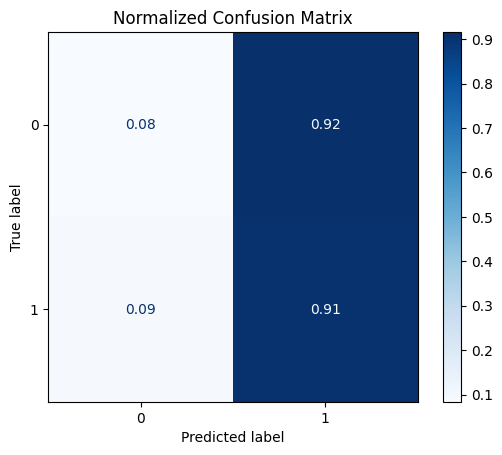

In [55]:
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = model.classes_)
disp.plot(cmap = 'Blues', values_format = ".2f")
plt.title("Normalized Confusion Matrix")
plt.show()

Random Forest Model

In [59]:
from sklearn.ensemble import RandomForestClassifier

In [60]:
preprocessor = ColumnTransformer(
    transformers = [
        ('numerical', MinMaxScaler(feature_range = (-1, 1)), numerical_columns),
    ]
)

In [73]:
forest_model = Pipeline(
    steps = [
        ('preprocess', preprocessor),
        ('classifier', RandomForestClassifier(n_jobs = -1, random_state = 7, n_estimators = 500, max_depth = 10, max_leaf_nodes = 150))
    ]
)

In [74]:
forest_model.fit(X_train, y_train)

,steps,"[('preprocess', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('numerical', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [75]:
forest_model.score(X_train, y_train), forest_model.score(X_test, y_test)

(0.9382276843467011, 0.5239327296248383)